In [1]:

import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
if not os.path.exists('./../scratch-cnn/data/'):
    os.mkdir('./../scratch-cnn/data/')

if not os.path.exists('./../scratch-cnn/data/empty/'):
    os.mkdir('./../scratch-cnn/data/empty/')

if not os.path.exists('./../scratch-cnn/data/no_empty/'):
    os.mkdir('./../scratch-cnn/data/no_empty/')

for filename in os.listdir('./../output/training_squares/'):
    if filename.endswith('.png'):
       
        txt_filename = os.path.join('./../output/training_squares/', f"{os.path.splitext(filename)[0]}.txt")

        # Verificare se il file di testo contiene "empty"
        with open(txt_filename, 'r') as file:
            contenuto = file.read()
            if 'empty' in contenuto:
                # Spostare l'immagine nella cartella empty
                shutil.copy(os.path.join('./../output/training_squares/', filename), os.path.join('./../scratch-cnn/data/empty/', filename))
            else:
                # Spostare l'immagine nella cartella non_empty
                shutil.copy(os.path.join('./../output/training_squares/', filename), os.path.join('./../scratch-cnn/data/no_empty/', filename))


display(len(os.listdir('./../scratch-cnn/data/empty/')))
display(len(os.listdir('./../scratch-cnn/data/no_empty/')))

FileNotFoundError: [WinError 3] Impossibile trovare il percorso specificato: './../output/training_squares/'

In [ ]:
dataset_path = './../scratch-cnn/data/'
class_names = ['empty', 'no_empty']
data = []
labels = []
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        data.append(img_path)
        labels.append(class_name)

data, labels = shuffle(data, labels, random_state=42)

# Split the data into training and temporary sets
train_data, temp_data, train_labels, temp_labels = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the temporary set into validation and test sets
test_data, validation_data, test_labels, validation_labels = train_test_split(temp_data, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

display(len(train_data))
display(len(validation_data))
display(len(test_data))
display(test_data)

537

116

115

['./../scratch-cnn/data/empty\\0001_D4.png',
 './../scratch-cnn/data/empty\\0280_F3.png',
 './../scratch-cnn/data/no_empty\\0000_A2.png',
 './../scratch-cnn/data/empty\\0292_B4.png',
 './../scratch-cnn/data/empty\\0001_H1.png',
 './../scratch-cnn/data/empty\\0347_D6.png',
 './../scratch-cnn/data/no_empty\\0000_A8.png',
 './../scratch-cnn/data/empty\\0206_C8.png',
 './../scratch-cnn/data/no_empty\\0292_C8.png',
 './../scratch-cnn/data/no_empty\\0231_C2.png',
 './../scratch-cnn/data/empty\\0206_E4.png',
 './../scratch-cnn/data/empty\\0024_H8.png',
 './../scratch-cnn/data/no_empty\\0231_F5.png',
 './../scratch-cnn/data/no_empty\\0000_H7.png',
 './../scratch-cnn/data/empty\\0001_C8.png',
 './../scratch-cnn/data/empty\\0132_E3.png',
 './../scratch-cnn/data/empty\\0280_E6.png',
 './../scratch-cnn/data/empty\\0347_D4.png',
 './../scratch-cnn/data/empty\\0280_A5.png',
 './../scratch-cnn/data/empty\\0292_E5.png',
 './../scratch-cnn/data/empty\\0231_H4.png',
 './../scratch-cnn/data/empty\\0206_H

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        # Carica l'immagine da file
        img = Image.open(img_path)

        # Applica le trasformazioni se specificate
        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# Definisci le trasformazioni per il tuo dataset (es. resizing, normalizzazione, ecc.)
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor()
])

In [ ]:
train_ds = CustomDataset(train_data, train_labels, transform=transform)
validation_ds = CustomDataset(validation_data, validation_labels, transform=transform)
test_ds = CustomDataset(test_data, test_labels, transform=transform)

In [ ]:
# Crea i dataloader
batch_size = 32
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Epoch 1/150, Training Loss: 0.6853503584861755, Validation Loss: 0.6558796763420105
Epoch 2/150, Training Loss: 0.6320744156837463, Validation Loss: 0.6419433355331421
Epoch 3/150, Training Loss: 0.679785966873169, Validation Loss: 0.6087189316749573
Epoch 4/150, Training Loss: 0.5372597575187683, Validation Loss: 0.5752452611923218
Epoch 5/150, Training Loss: 0.5002915859222412, Validation Loss: 0.5444414019584656
Epoch 6/150, Training Loss: 0.7254219651222229, Validation Loss: 0.5700402855873108
Epoch 7/150, Training Loss: 0.5584484934806824, Validation Loss: 0.5584022998809814
Epoch 8/150, Training Loss: 0.5547976493835449, Validation Loss: 0.5120199918746948
Epoch 9/150, Training Loss: 0.5683522820472717, Validation Loss: 0.49001556634902954
Epoch 10/150, Training Loss: 0.5100500583648682, Validation Loss: 0.46653103828430176
Epoch 11/150, Training Loss: 0.387073814868927, Validation Loss: 0.46159276366233826
Epoch 12/150, Training Loss: 0.39942699670791626, Validation Loss: 0.4770

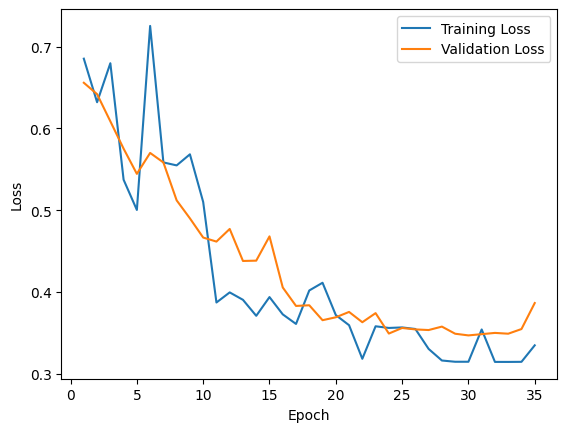

Test Accuracy: 88.70%


In [ ]:
# Definisci la tua rete CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 20 * 20, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)  # Due classi: empty e no_empty

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        probabilities = F.softmax(x, dim=1)
        return probabilities

# Inizializza la rete
model = SimpleCNN()

# Definisci la loss function e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definisci il numero di epoche per il training
num_epochs = 150

# Inizializza le variabili per l'early stopping
best_valid_loss = float('inf')
early_stopping_patience = 10  # Sostituisci con il tuo valore desiderato
early_stopping_counter = 0

# Liste per salvare i valori di loss
train_losses = []
validation_losses = []

# Training della rete
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.tensor([class_names.index(label) for label in labels]))
        loss.backward()
        optimizer.step()

    # Valutazione sul set di validazione
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        for inputs, labels in validation_dataloader:
            outputs = model(inputs)
            valid_loss += criterion(outputs, torch.tensor([class_names.index(label) for label in labels]))

    # Calcola la media della loss sul set di validazione
    valid_loss /= len(validation_dataloader)

    # Aggiorna le liste di loss
    train_losses.append(loss.item())
    validation_losses.append(valid_loss.item())

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {valid_loss.item()}')

    # Controlla se la loss sul set di validazione è migliorata
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stopping_counter = 0
    else:
        # Incrementa il contatore di early stopping
        early_stopping_counter += 1

    # Se la loss non migliora per un numero specifico di epoche, interrompi il training
    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping after {epoch + 1} epochs without improvement.')
        break

'''
import matplotlib.pyplot as plt


# Plot dei valori di training loss e validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
'''

# Test della rete
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += len(labels)
        correct += (predicted == torch.tensor([class_names.index(label) for label in labels])).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')


In [ ]:
'''model.eval()
correct = 0
total = 0
c = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += len(labels)
        correct += (predicted == torch.tensor([class_names.index(label) for label in labels])).sum().item()

        # Stampa per ogni input corretto o non corretto
        for i in range(len(labels)):
            prediction_correct = (predicted[i] == class_names.index(labels[i]))
            print(f"Input {c}: {'Correct' if prediction_correct else 'Incorrect'}")
            c=c+1
            print(f"   Predicted: {class_names[predicted[i]]}, True: {labels[i]}\n")

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')
'''

Input 0: Correct
   Predicted: empty, True: empty

Input 1: Incorrect
   Predicted: no_empty, True: empty

Input 2: Correct
   Predicted: no_empty, True: no_empty

Input 3: Correct
   Predicted: empty, True: empty

Input 4: Correct
   Predicted: empty, True: empty

Input 5: Correct
   Predicted: empty, True: empty

Input 6: Correct
   Predicted: no_empty, True: no_empty

Input 7: Correct
   Predicted: empty, True: empty

Input 8: Incorrect
   Predicted: empty, True: no_empty

Input 9: Incorrect
   Predicted: empty, True: no_empty

Input 10: Correct
   Predicted: empty, True: empty

Input 11: Correct
   Predicted: empty, True: empty

Input 12: Incorrect
   Predicted: empty, True: no_empty

Input 13: Correct
   Predicted: no_empty, True: no_empty

Input 14: Correct
   Predicted: empty, True: empty

Input 15: Correct
   Predicted: empty, True: empty

Input 16: Correct
   Predicted: empty, True: empty

Input 17: Correct
   Predicted: empty, True: empty

Input 18: Correct
   Predicted: empt

In [ ]:
display(test_data[146])

IndexError: list index out of range

In [ ]:
img_path = './../scratch-cnn/data/no_empty/0026_E8.png'

img = Image.open(img_path)

img = transform(img)
img = img.reshape([1, 3, 80, 80])
display(img.shape)

with torch.no_grad():
    output = model(img)
    display(output)

torch.Size([1, 3, 80, 80])

tensor([[1.0000e+00, 6.7168e-11]])

In [ ]:
from torchsummary import summary
import torch.onnx



# Mostra una rappresentazione tabulare del modello
summary(model, input_size=(3, 80, 80))  # Cambia le dimensioni in base alla tua immagine di input

# Salva il modello in formato ONNX
dummy_input = torch.randn(1, 3, 80, 80)  # Cambia le dimensioni in base alla tua immagine di input
onnx_path = "simple_cnn.onnx"
torch.onnx.export(model, dummy_input, onnx_path)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 80, 80]             448
              ReLU-2           [-1, 16, 80, 80]               0
         MaxPool2d-3           [-1, 16, 40, 40]               0
            Conv2d-4           [-1, 32, 40, 40]           4,640
              ReLU-5           [-1, 32, 40, 40]               0
         MaxPool2d-6           [-1, 32, 20, 20]               0
           Flatten-7                [-1, 12800]               0
            Linear-8                  [-1, 128]       1,638,528
              ReLU-9                  [-1, 128]               0
           Linear-10                    [-1, 2]             258
Total params: 1,643,874
Trainable params: 1,643,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.07
Forward/backward pass size (MB): 2.74
Params size (MB): 6.27
Estimat